
## Project:Medical Representative

Medical representatives are the key point of contact between
pharmaceutical and medical companies and healthcare professionals.
A medical representative's job is to promote and sell their company's
products, whether that's pharmaceutical drugs or medical equipment.
Customers can include doctors, nurses and pharmacists. The medical
representative will increase product awareness, answer queries,
company.

The job of medical representative has a lot of challenges but the most
important one is how the medical representative convinces a doctor to write a
drug from the medical company which he works for in his prescription where
there are many competitors' drugs that have the same active ingredient from
other companies.
The goal is to know if a doctor with some
specific features will write or not one of 6 drugs for a medical
company that has license to produce several types of local produced
drugs with the same active ingredients of multinational original drugs.

## Exploring the Data
In this part i'm going to explore the data and all the features.

### Datasets and Inputs
The dataset was collected by me in a year from private clinics,
hospitals and pharmacies
All data are public data that was collected from doctors and
pharmacists about 6 drugs produced by a certain medical company.


In [4]:
import numpy as np
import pandas as pd
from IPython.display import display     # Allows the use of display() for DataFrames
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Pretty display for notebooks
%matplotlib inline
%load_ext sql

con = sqlite3.connect("med.db")
cur = con.cursor()
%sql sqlite:///med.db

## Featureset Exploration
### Input Data fields (Features and Labels)
The input data consists of 390 samples collected from 253 doctors.
This data will be used for training and validation test in a data base file
named 'med' attached with the project proposal.
the data in database called med and splited in two tables connected by the id column.
#### table 1 : medicine_table
* **id_m:** row id for every medicine
* **medicine:** The commercial name of the medicine that I refer to it as type1 to type6.
* **Price:** price for every drug of these 6 drugs for patient.

#### table 2 : doctor_table
* **id_dr:** row id for every doctor
* **exam_price:** examination price that the doctor takes from the patient.
* **clinic_hos:** classification if this doctor has a private 'clinic' or works in a 'hospital'.
* **dr_class:** doctor class was classified according to number of patients for every doctor and how much is this doctor famous and it was classified to 'a' and 'b'.

**where:**

* **class a:** are doctors with high patient rate
* **class b:** are doctors with medium patient rate
* **area:** every medical representative cover some areas in a city where the medical representative has to make a lot of visits for alot of doctors in different places and I refer to each area with the name (area1 to area8)with total 8 areas that I have covered to make my prospection.
* **specialty:** the specialty of the doctor is one of the most important features because it will determine which of the 6 drugs will be suitable for this doctor to write it in his prescription. 

**These specialties are:**
* **Chest:** chest specialist
* **Im:** internal medicine specialist
* **Cd:** cardiology specialist
* **Neuro:** neurology specialist
* **Git:** gastrointestinal tract specialist
* **Ent:** ear, nose and throat specialist
* **Sur:** surgery specialist
* **Uro:** urology specialist
* **Gp:** general practitioner
* **Or:** orthopedic specialist
* **Vas:** vascular specialst

**With total 11 specialties.**

* **Target (label):** just one target to classify if this doctor write any of these drugs in prescription to his patients or not. With (1) if the doctor writes the drug in his prescription and (0) if not.

In [6]:
medicine_table = %sql SELECT * FROM medicine_table;
medicine_table = medicine_table.DataFrame()
display(medicine_table.head())

 * sqlite:///med.db
Done.


,id_m,medicine,price
0,1,type1,45
1,2,type4,36
2,3,type1,45
3,4,type1,45
4,5,type5,29


In [7]:
doctor_table = %sql SELECT * FROM doctor_table ;

 * sqlite:///med.db
Done.


## Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of doctors who wrote any of the 6 drugs in their prescription. In the code cell below, i will compute the following:

The total number of records, 'n_records'

The number of doctors who wrote any of the 6 drugs in their prescription, 'n_doctor_who_write'.

The number of doctors who didn't write any of the 6 drugs in their prescription, 'n_doctor_who_not_write'.

The percentage of doctors who wrote any of the 6 drugs in their prescription , 'write_percent'.

In [9]:
# Fetch data from both tables
medicine_table = pd.read_sql_query("SELECT * FROM medicine_table", con)
doctor_table = pd.read_sql_query("SELECT * FROM doctor_table", con)

# Merge both tables on the id (assuming the connection between tables is based on an id column)
merged_data = pd.merge(medicine_table, doctor_table, left_on='id_m', right_on='id_dr', how='inner')

# Display the first few rows of the merged dataset
display(merged_data.head())

# Calculate the total number of records (doctors)
n_records = merged_data.shape[0]

# Count the number of doctors who wrote any of the 6 drugs (column 'write' with value 1)
n_doctor_who_write = merged_data[merged_data['write'] == 1].shape[0]

# Count the number of doctors who didn't write any of the 6 drugs (column 'write' with value 0)
n_doctor_who_not_write = merged_data[merged_data['write'] == 0].shape[0]

# Calculate the percentage of doctors who wrote the drug
write_percent = (n_doctor_who_write / n_records) * 100

# Print the results
print(f"Total number of records: {n_records}")
print(f"Number of doctors who wrote any of the 6 drugs: {n_doctor_who_write}")
print(f"Number of doctors who did not write any of the 6 drugs: {n_doctor_who_not_write}")
print(f"Percentage of doctors who wrote any of the 6 drugs: {write_percent:.2f}%")


,id_m,medicine,price,id_dr,area,speciality,dr_class,exam_price,clinic_hos,write
0,1,type1,45,1,area1,chest,a,200,clinic,1
1,2,type4,36,2,area2,im,b,100,clinic,1
2,3,type1,45,3,area8,chest,a,75,hospital,1
3,4,type1,45,4,area5,chest,a,30,hospital,1
4,5,type5,29,5,area6,uro,a,220,clinic,0


Total number of records: 390
Number of doctors who wrote any of the 6 drugs: 229
Number of doctors who did not write any of the 6 drugs: 161
Percentage of doctors who wrote any of the 6 drugs: 58.72%


# Phase 2

In [11]:
print(merged_data.columns)


Index(['id_m', 'medicine', 'price', 'id_dr', 'area', 'speciality', 'dr_class',
       'exam_price', 'clinic_hos', 'write'],
      dtype='object')


In [12]:
# Check for missing values in the dataset
missing_values = merged_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Impute missing values based on column types
# For numeric columns, use the mean or median
# Impute missing values for 'exam_price'
merged_data['exam_price'] = merged_data['exam_price'].fillna(merged_data['exam_price'].mean())

# Check for duplicates
duplicate_rows = merged_data[merged_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Remove duplicates
merged_data = merged_data.drop_duplicates()

# Verify if duplicates are removed
print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

# Check unique values in categorical columns for inconsistencies
print("Unique values:\n", merged_data.select_dtypes(include='object').nunique())

# Encode categorical variables with one-hot encoding
new = pd.get_dummies(merged_data, columns=['medicine', 'area'  ,'speciality'], drop_first=True)  

# Display the first few rows to confirm encoding
display(merged_data.head())
display(new.head())
# Final check of the cleaned data
print("Final dataset info:\n")
print(merged_data.info())
print(merged_data.columns)
print(new.info())
print(new.columns)

Missing values in each column:
 id_m          0
medicine      0
price         0
id_dr         0
area          0
speciality    0
dr_class      0
exam_price    0
clinic_hos    0
write         0
dtype: int64
Number of duplicate rows: 0
Number of rows after removing duplicates: 390
Unique values:
 medicine       6
area           8
speciality    11
dr_class       2
clinic_hos     2
dtype: int64


,id_m,medicine,price,id_dr,area,speciality,dr_class,exam_price,clinic_hos,write
0,1,type1,45,1,area1,chest,a,200,clinic,1
1,2,type4,36,2,area2,im,b,100,clinic,1
2,3,type1,45,3,area8,chest,a,75,hospital,1
3,4,type1,45,4,area5,chest,a,30,hospital,1
4,5,type5,29,5,area6,uro,a,220,clinic,0


,id_m,price,id_dr,dr_class,exam_price,clinic_hos,write,medicine_type2,medicine_type3,medicine_type4,...,speciality_chest,speciality_ent,speciality_git,speciality_gp,speciality_im,speciality_neuro,speciality_or,speciality_sur,speciality_uro,speciality_vas
0,1,45,1,a,200,clinic,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,2,36,2,b,100,clinic,1,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,3,45,3,a,75,hospital,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,4,45,4,a,30,hospital,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,5,29,5,a,220,clinic,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Final dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_m        390 non-null    int64 
 1   medicine    390 non-null    object
 2   price       390 non-null    int64 
 3   id_dr       390 non-null    int64 
 4   area        390 non-null    object
 5   speciality  390 non-null    object
 6   dr_class    390 non-null    object
 7   exam_price  390 non-null    int64 
 8   clinic_hos  390 non-null    object
 9   write       390 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 30.6+ KB
None
Index(['id_m', 'medicine', 'price', 'id_dr', 'area', 'speciality', 'dr_class',
       'exam_price', 'clinic_hos', 'write'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  --

# Phase 3

In [14]:
new[['dr_class', 'clinic_hos']] = new[['dr_class', 'clinic_hos']].apply(
    lambda x: x.str.strip().map({'b': 0, 'a': 1}) if x.name == 'dr_class' else x.str.strip().map({'clinic': 1, 'hospital': 0})
)
new

,id_m,price,id_dr,dr_class,exam_price,clinic_hos,write,medicine_type2,medicine_type3,medicine_type4,...,speciality_chest,speciality_ent,speciality_git,speciality_gp,speciality_im,speciality_neuro,speciality_or,speciality_sur,speciality_uro,speciality_vas
0,1,45,1,1,200,1,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,2,36,2,0,100,1,1,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,3,45,3,1,75,0,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,4,45,4,1,30,0,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,5,29,5,1,220,1,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,29,386,0,75,0,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
386,387,30,387,0,70,0,0,True,False,False,...,False,False,False,False,True,False,False,False,False,False
387,388,45,388,1,120,1,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False
388,389,45,389,0,75,0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [15]:
new = new.astype(float)
new

,id_m,price,id_dr,dr_class,exam_price,clinic_hos,write,medicine_type2,medicine_type3,medicine_type4,...,speciality_chest,speciality_ent,speciality_git,speciality_gp,speciality_im,speciality_neuro,speciality_or,speciality_sur,speciality_uro,speciality_vas
0,1.0,45.0,1.0,1.0,200.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,36.0,2.0,0.0,100.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.0,45.0,3.0,1.0,75.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,45.0,4.0,1.0,30.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,29.0,5.0,1.0,220.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386.0,29.0,386.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
386,387.0,30.0,387.0,0.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
387,388.0,45.0,388.0,1.0,120.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
388,389.0,45.0,389.0,0.0,75.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Correlation

In [17]:
# Calculate correlation matrix
corr = new.corr()['write']
corr


id_m                0.013438
price              -0.015387
id_dr               0.013438
dr_class           -0.415760
exam_price         -0.312110
clinic_hos         -0.076308
write               1.000000
medicine_type2     -0.038812
medicine_type3      0.053860
medicine_type4      0.009706
medicine_type5      0.025706
medicine_type6     -0.025766
area_area2          0.077716
area_area3          0.006054
area_area4          0.029665
area_area5          0.008473
area_area6          0.037310
area_area7         -0.030705
area_area8         -0.051260
speciality_chest    0.132323
speciality_ent     -0.053779
speciality_git     -0.007053
speciality_gp       0.124783
speciality_im      -0.040120
speciality_neuro   -0.004325
speciality_or       0.044600
speciality_sur     -0.059861
speciality_uro     -0.061674
speciality_vas     -0.099108
Name: write, dtype: float64

## Visualizing Data with Plots

### Histograms:

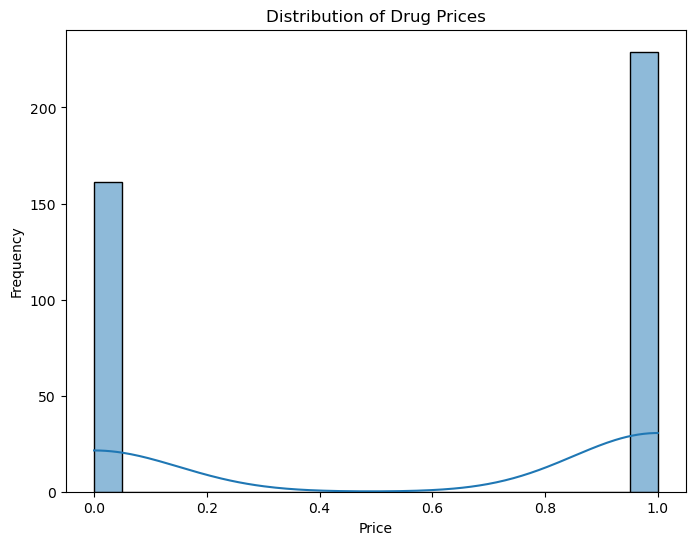

In [20]:
# Distribution of write
plt.figure(figsize=(8, 6))
sns.histplot(new['write'], bins=20, kde=True)
plt.title('Distribution of Drug Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



### Bar Plots:

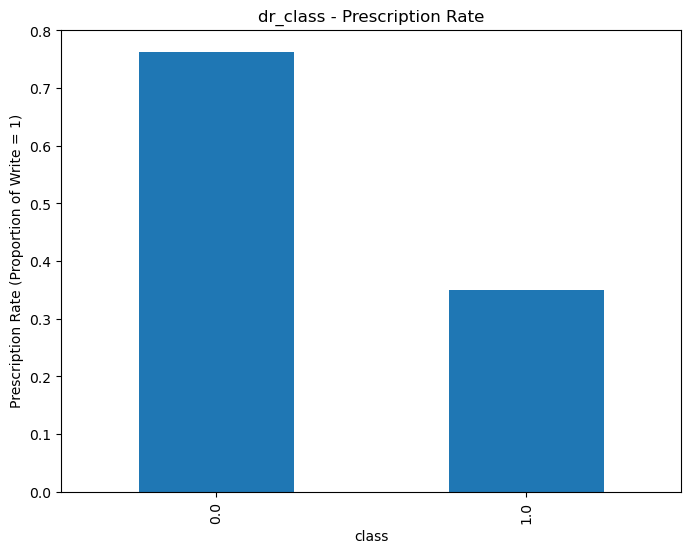

In [22]:
# Bar plot for speciality vs write (e.g., chest specialists prescribing behavior)
speciality_write = new.groupby(['dr_class'])['write'].mean()

plt.figure(figsize=(8, 6))
speciality_write.plot(kind='bar')
plt.title('dr_class - Prescription Rate')
plt.xlabel('class')
plt.ylabel('Prescription Rate (Proportion of Write = 1)')
plt.show()


### Scatter Plots:

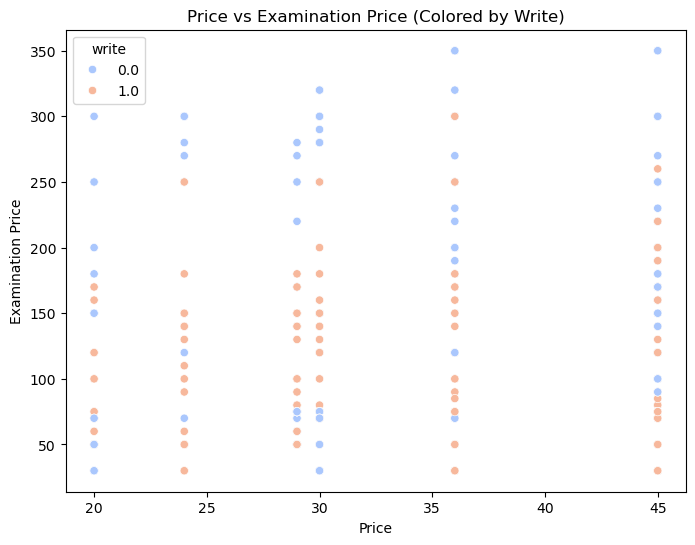

In [24]:
# Scatter plot for price vs exam_price colored by write
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='exam_price', hue='write', data=new, palette='coolwarm')
plt.title('Price vs Examination Price (Colored by Write)')
plt.xlabel('Price')
plt.ylabel('Examination Price')
plt.show()


# Phase 4

## Feature Engineering

### Interaction Features

In [28]:
# Interaction between exam_price and price (e.g., exam_price per price unit)
new['exam_per_price'] = new['exam_price'] / new['price']
# Create a binary feature based on whether the exam price is high or low
new['high_exam_price'] = (new['exam_price'] > new['exam_price'].median()).astype(int)
# Ratio of exam price to drug price
new['exam_to_drug_price_ratio'] = new['exam_price'] / new['price']
# Combine clinic_hos and dr_class to create an interaction feature
new['clinic_hos_dr_class'] = new['clinic_hos'] * new['dr_class']


### Data Clustering with K-Means

C:\Users\karim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


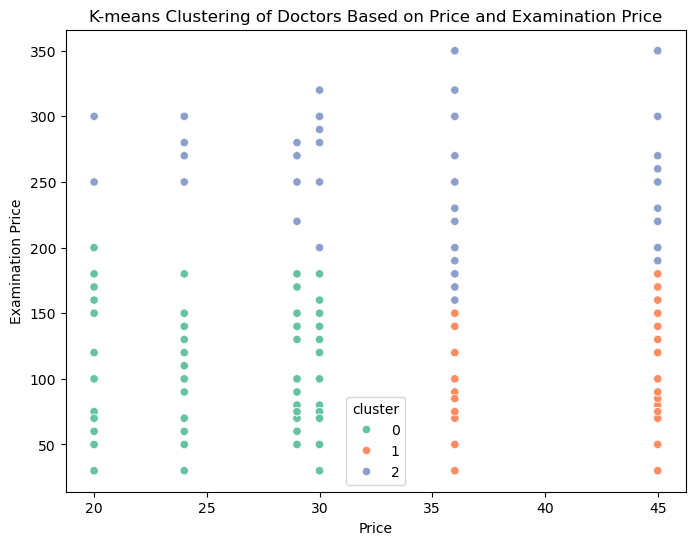

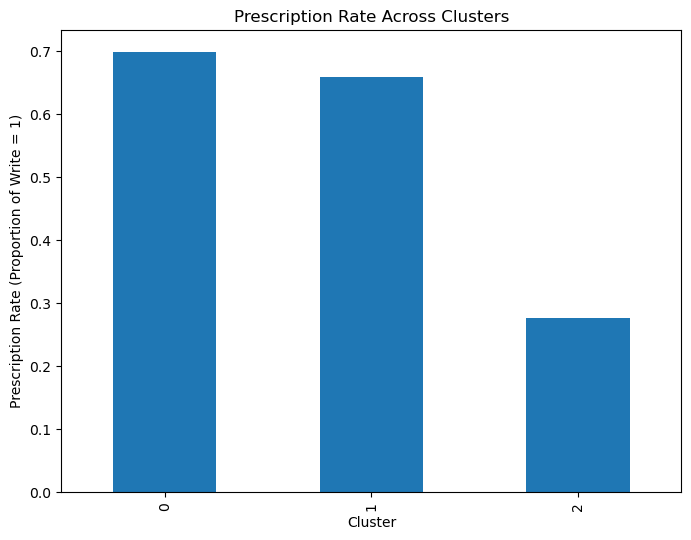

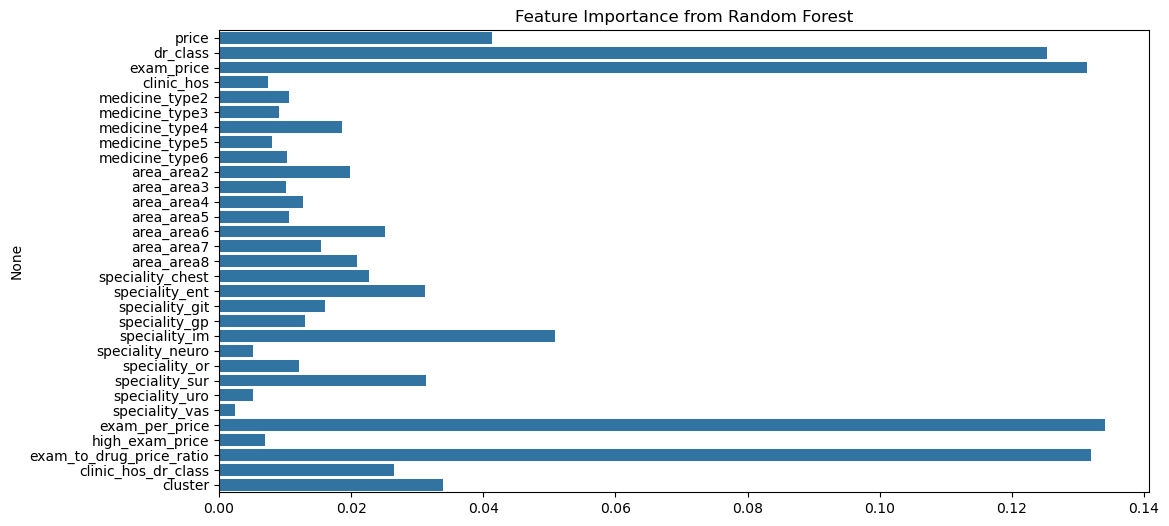

In [30]:
import os
os.environ['OMP_NUM_THREADS'] = '2'

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features for clustering
cluster_features = new[['price', 'exam_price']]

# Standardize the features before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Apply K-means clustering with 3 clusters (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
new['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='exam_price', hue='cluster', data=new, palette='Set2')
plt.title('K-means Clustering of Doctors Based on Price and Examination Price')
plt.xlabel('Price')
plt.ylabel('Examination Price')
plt.show()

# Analyze prescription behavior across clusters
cluster_prescription = new.groupby('cluster')['write'].mean()

plt.figure(figsize=(8, 6))
cluster_prescription.plot(kind='bar')
plt.title('Prescription Rate Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Prescription Rate (Proportion of Write = 1)')
plt.show()

# Drop unnecessary columns like 'id_m' and 'id_dr'
X = new.drop(columns=['write', 'id_m', 'id_dr'])  # Features
y = new['write']  # Target

# Train a Random Forest model to evaluate feature importance
rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)

# Feature importance
importances = rf.feature_importances_
features = X.columns

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance from Random Forest')
plt.show()


# Phase 5

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# 1. Drop unnecessary columns and separate features and target variable
X = new.drop(columns=['write', 'id_m', 'id_dr'], errors='ignore')  # Features, ignoring errors for dropped columns
y = new['write']  # Target

# 3. Create pipelines for scaling and encoding


# 4. Apply the transformations using a pipeline

# 5. Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Display the shapes of the training and testing sets
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")


Training set size: (312, 31), Testing set size: (78, 31)


# Phase 6

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Initialize the models
decision_tree = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# 2. Train and evaluate models
models = [decision_tree, svc, random_forest]
model_names = ['Decision Tree', 'SVC', 'Random Forest']

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1

# 3. Iterate over each model and evaluate
for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    print(f"{name} Model:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("="*30)

# 4. Perform cross-validation to check model robustness
for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
    print("="*30)


Decision Tree Model:
Accuracy: 0.74
Precision: 0.85
Recall: 0.75
F1 Score: 0.80
SVC Model:
Accuracy: 0.74
Precision: 0.74
Recall: 0.96
F1 Score: 0.83
Random Forest Model:
Accuracy: 0.78
Precision: 0.81
Recall: 0.88
F1 Score: 0.84
Decision Tree Cross-Validation Accuracy: 0.61 ± 0.03
SVC Cross-Validation Accuracy: 0.69 ± 0.01
Random Forest Cross-Validation Accuracy: 0.64 ± 0.03


# Phase 7

## Evaluate Performance Metrics

In [37]:
from sklearn.model_selection import GridSearchCV

# 1. Hyperparameter tuning for Decision Tree
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=0), dt_params, cv=5, scoring='f1')
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")
print(f"Best Decision Tree F1-Score: {dt_grid.best_score_:.2f}")

# 2. Hyperparameter tuning for SVC
svc_params = {
    'C': [0.1, 1, 10],         
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']         


svc_grid = GridSearchCV(SVC(random_state=0), svc_params, cv=5, scoring='f1')
svc_grid.fit(X_train, y_train)
best_svc = svc_grid.best_estimator_

print(f"Best SVC Parameters: {svc_grid.best_params_}")
print(f"Best SVC F1-Score: {svc_grid.best_score_:.2f}")

# 3. Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=0), rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best Random Forest F1-Score: {rf_grid.best_score_:.2f}")


Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best Decision Tree F1-Score: 0.69
Best SVC Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVC F1-Score: 0.78
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
Best Random Forest F1-Score: 0.74


In [62]:
from sklearn.metrics import classification_report

# Evaluate the best Decision Tree
y_pred_dt = best_dt.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Evaluate the best SVC
y_pred_svc = best_svc.predict(X_test)
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))

# Evaluate the best Random Forest
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.54      0.58        26
         1.0       0.79      0.85      0.81        52

    accuracy                           0.74        78
   macro avg       0.71      0.69      0.70        78
weighted avg       0.74      0.74      0.74        78

SVC Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.31      0.44        26
         1.0       0.74      0.96      0.83        52

    accuracy                           0.74        78
   macro avg       0.77      0.63      0.64        78
weighted avg       0.76      0.74      0.70        78

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.50      0.59        26
         1.0       0.78      0.90      0.84        52

    accuracy                           0.77        78
   macro avg       0.75 

In [74]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

models = {
    'RandomForest': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42),
    'SVC': SVC(class_weight='balanced', random_state=42),
    'MLP': MLPClassifier(random_state=42)
}

svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svc = SVC(random_state=42, class_weight='balanced')
grid_search_svc = GridSearchCV(svc, svc_param_grid, scoring='accuracy', cv=5)
grid_search_svc.fit(X_train_resampled, y_train_resampled)
best_svc = grid_search_svc.best_estimator_

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    print(f"****** {model_name} ******")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

y_pred_svc = best_svc.predict(X_test_scaled)
print("****** Best SVC (GridSearchCV) ******")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print(f"F1 Score: {f1_score(y_test, y_pred_svc):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print("Best Parameters:", grid_search_svc.best_params_)


****** RandomForest ******
Confusion Matrix:
 [[18  8]
 [ 6 46]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.69      0.72        26
         1.0       0.85      0.88      0.87        52

    accuracy                           0.82        78
   macro avg       0.80      0.79      0.79        78
weighted avg       0.82      0.82      0.82        78

F1 Score: 0.8679
Accuracy: 0.8205

****** AdaBoost ******
Confusion Matrix:
 [[19  7]
 [12 40]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.73      0.67        26
         1.0       0.85      0.77      0.81        52

    accuracy                           0.76        78
   macro avg       0.73      0.75      0.74        78
weighted avg       0.77      0.76      0.76        78

F1 Score: 0.8081
Accuracy: 0.7564

****** SVC ******
Confusion Matrix:
 [[22  4]
 [17 35]]
Classification Report:
               precisio

C:\Users\karim\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


****** MLP ******
Confusion Matrix:
 [[19  7]
 [12 40]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.73      0.67        26
         1.0       0.85      0.77      0.81        52

    accuracy                           0.76        78
   macro avg       0.73      0.75      0.74        78
weighted avg       0.77      0.76      0.76        78

F1 Score: 0.8081
Accuracy: 0.7564

****** Best SVC (GridSearchCV) ******
Confusion Matrix:
 [[21  5]
 [15 37]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.81      0.68        26
         1.0       0.88      0.71      0.79        52

    accuracy                           0.74        78
   macro avg       0.73      0.76      0.73        78
weighted avg       0.78      0.74      0.75        78

F1 Score: 0.7872
Accuracy: 0.7436
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


C:\Users\karim\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

def model_building_rf():
    model = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=200, max_depth=10)  # Random Forest model with class balancing
    model.fit(X_train, y_train)  

    y_test_pred = model.predict(X_test)  
    y_train_pred = model.predict(X_train)  

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"******** Model :- {model.__class__.__name__} ********")
    print(f"Training F1 Score: {train_f1:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing F1 Score: {test_f1:.4f}, Testing Accuracy: {test_accuracy:.4f}")
    print()

model_building_rf()


******** Model :- RandomForestClassifier ********
Training F1 Score: 0.9096, Training Accuracy: 0.8974
Testing F1 Score: 0.8679, Testing Accuracy: 0.8205

